## Import

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import os, sys
from PIL import Image

from utils.helpers import *

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

PATCH_SIZE = 16

## Load the data

In [12]:
def load_data(root_training_dir,root_test_dir):
    image_dir = root_training_dir + "images/"
    gt_dir = root_training_dir + "groundtruth/"

    files_train = os.listdir(image_dir)
    folder_test = os.listdir(root_test_dir)

    n_train = len(files_train)
    n_test = len(folder_test)


    imgs = [load_image(image_dir + files_train[i]) for i in range(n_train)]

    gt_imgs = [load_image(gt_dir + files_train[i]) for i in range(n_train)]


    imgs_test = [ load_image(os.path.join(root_test_dir, folder_test[i], f"{folder_test[i]}.png")) for i in range(n_test)]
    
    return imgs,gt_imgs,imgs_test,n_train,image_dir,files_train

In [14]:
root_training_dir = "dataset/training/"
root_aumg_training_dir = "dataset/augmented_training/"

root_test_dir = "dataset/test_set_images/"


imgs,gt_imgs,imgs_test,n_train,image_dir,files_train = load_data(root_training_dir,root_test_dir)
augm_imgs,augm_gt_imgs,imgs_test,augm_n_train,_,_ = load_data(root_aumg_training_dir,root_test_dir)
print(n_train,augm_n_train)

100 200


## Extract patches from input images

In [16]:
def extract_patches(patch_size,imgs,gt_imgs,n_train):

    img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n_train)]
    gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n_train)]

    # Convert to numpy arrays
    img_patches = np.array(img_patches)
    gt_patches = np.array(gt_patches)

    print(f"Shape of unflattened image patches : {img_patches.shape}\n"
          f"Shape of unflattened ground truth patches : {gt_patches.shape} \n")

    # Linearize list of patches
    img_patches = np.asarray(
        [
            img_patches[i][j]
            for i in range(len(img_patches))
            for j in range(len(img_patches[i]))
        ]
    )
    gt_patches = np.asarray(
        [
            gt_patches[i][j]
            for i in range(len(gt_patches))
            for j in range(len(gt_patches[i]))
        ]
    )
    print(f"Shape of flattened image patches : {img_patches.shape}\n"
          f"Shape of flattened ground truth patches : {gt_patches.shape} \n\n\n")
    return img_patches,gt_patches

In [17]:
img_patches,gt_patches = extract_patches(PATCH_SIZE,imgs,gt_imgs,n_train)
augm_img_patches,augm_gt_patches = extract_patches(PATCH_SIZE,augm_imgs,augm_gt_imgs,augm_n_train)

Shape of unflattened image patches : (100, 625, 16, 16, 3)
Shape of unflattened ground truth patches : (100, 625, 16, 16) 

Shape of flattened image patches : (62500, 16, 16, 3)
Shape of flattened ground truth patches : (62500, 16, 16) 



Shape of unflattened image patches : (200, 625, 16, 16, 3)
Shape of unflattened ground truth patches : (200, 625, 16, 16) 

Shape of flattened image patches : (125000, 16, 16, 3)
Shape of flattened ground truth patches : (125000, 16, 16) 





## Feature extraction
In order to build features for the logistic regression, we can work with different features extration methods, indeed we can extract:
- 2 features: The mean and std of grey color
- 6 features: The mean and std for the three RGB colors: 2*3=6

- What if we try 8 features by summing the two methods?

In [19]:
def feature_extraction(img_patches,gt_patches):
    X2d = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    X6d = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
    X8d = np.asarray([np.concatenate((X2d[i], X6d[i])) for i in range(len(X2d))])


    print("Dimensions of the three different feature extraction methods (2D,6D,8D): {},{} and {}\n".format(X2d.shape,X6d.shape,X8d.shape))

    
    return X2d,X6d,X8d

def label_extraction(gt_patches,foreground_threshold = 0.25):
    y = np.asarray([value_to_class(np.mean(gt_patches[i]),foreground_threshold = 0.25) for i in range(len(gt_patches))])
    return y

In [20]:
y = label_extraction(gt_patches)
y_augm = label_extraction(augm_gt_patches)

X2d,X6d,X8d = feature_extraction(img_patches,gt_patches)
X2d_augm,X6d_augm,X8d_augm = feature_extraction(augm_img_patches,augm_gt_patches)

Dimensions of the three different feature extraction methods (2D,6D,8D): (62500, 2),(62500, 6) and (62500, 8)

Dimensions of the three different feature extraction methods (2D,6D,8D): (125000, 2),(125000, 6) and (125000, 8)



For visualization, let's plot the distribution of road vs non-road patches (the first 1000 patchs for clarity) for the simple case of 2D features (grey mean and variance)

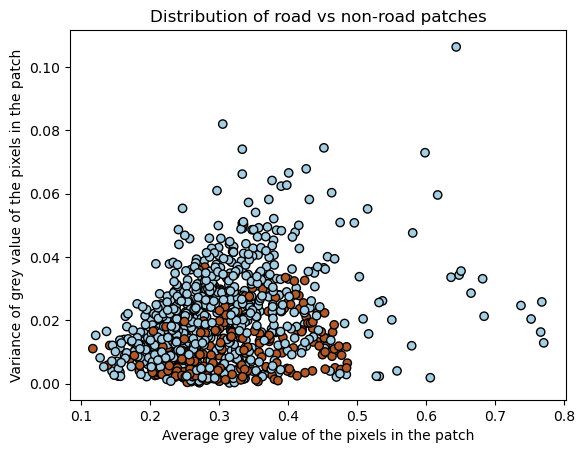

In [22]:
# Plot 2d features using groundtruth to color the datapoints
plt.scatter(X2d[:1000, 0], X2d[:1000, 1], c=y[:1000], edgecolors="k", cmap=plt.cm.Paired)

plt.title("Distribution of road vs non-road patches")
plt.xlabel("Average grey value of the pixels in the patch")
plt.ylabel("Variance of grey value of the pixels in the patch")
plt.show()

In [23]:
X_train_X2d, X_test_X2d, y_train_2d, y_test_2d = train_test_split(X2d, y, test_size=0.2, random_state=42)
X_train_X6d, X_test_X6d, y_train_6d, y_test_6d = train_test_split(X6d, y, test_size=0.2, random_state=42)
X_train_X8d, X_test_X8d, y_train_8d, y_test_8d = train_test_split(X8d, y, test_size=0.2, random_state=42)

X_train_X2d_augm, X_test_X2d_augm, y_train_2d_augm, y_test_2d_augm = train_test_split(X2d_augm, y_augm, test_size=0.2, random_state=42)
X_train_X6d_augm, X_test_X6d_augm, y_train_6d_augm, y_test_6d_augm = train_test_split(X6d_augm, y_augm, test_size=0.2, random_state=42)
X_train_X8d_augm, X_test_X8d_augm, y_train_8d_augm, y_test_8d_augm = train_test_split(X8d_augm, y_augm, test_size=0.2, random_state=42)

print("For the initial dataset, we have computed {} features; {} for training, and {} for validation.\n".format(len(X2d),len(X_train_X2d),len(X_test_X2d)))
print("For the augmented dataset, we have computed {} features; {} for training, and {} for validation.".format(len(X2d_augm),len(X_train_X2d_augm),len(X_test_X2d_augm)))

For the initial dataset, we have computed 62500 features; 50000 for training, and 12500 for validation.

For the augmented dataset, we have computed 125000 features; 100000 for training, and 25000 for validation.


In [24]:
from sklearn.preprocessing import StandardScaler

def standardization(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled , scaler

x_train_stand_2d, x_test_stand_2d, scaler2d = standardization(X_train_X2d, X_test_X2d)
x_train_stand_6d, x_test_stand_6d, scaler6d = standardization(X_train_X6d, X_test_X6d)
x_train_stand_8d, x_test_stand_8d, scaler8d = standardization(X_train_X8d, X_test_X8d)

x_train_stand_2d_augm, x_test_stand_2d_augm, scaler2d_augm = standardization(X_train_X2d_augm, X_test_X2d_augm)
x_train_stand_6d_augm, x_test_stand_6d_augm, scaler6d_augm = standardization(X_train_X6d_augm, X_test_X6d_augm)
x_train_stand_8d_augm, x_test_stand_8d_augm, scaler8d_augm = standardization(X_train_X8d_augm, X_test_X8d_augm)

## Hyperparameter selection

In [12]:
best_model_2d, best_params_2d, best_f1_2d = optimize_logistic_regression(x_train_stand_2d, y_train_2d)
best_model_6d, best_params_6d, best_f1_6d = optimize_logistic_regression(x_train_stand_6d, y_train_6d)
best_model_8d, best_params_8d, best_f1_8d = optimize_logistic_regression(x_train_stand_8d, y_train_8d)

best_model_2d_augm, best_params_2d_augm, best_f1_2d_augm = optimize_logistic_regression(x_train_stand_2d_augm, y_train_2d_augm)
best_model_6d_augm, best_params_6d_augm, best_f1_6d_augm = optimize_logistic_regression(x_train_stand_6d_augm, y_train_6d_augm)
best_model_8d_augm, best_params_8d_augm, best_f1_8d_augm = optimize_logistic_regression(x_train_stand_8d_augm, y_train_8d_augm)

Fitting 3 folds for each of 326 candidates, totalling 978 fits
Fitting 3 folds for each of 326 candidates, totalling 978 fits
Fitting 3 folds for each of 326 candidates, totalling 978 fits
Fitting 3 folds for each of 326 candidates, totalling 978 fits
Fitting 3 folds for each of 326 candidates, totalling 978 fits
Fitting 3 folds for each of 326 candidates, totalling 978 fits


In [13]:
print("For the initial data set, we have:\n")
print("For 2 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_2d,best_model_2d))
print("For 6 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_6d,best_model_6d))
print("For 8 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_8d,best_model_8d))

print("\n\n\nFor the augmented data set, we have:\n")
print("For 2 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_2d_augm,best_model_2d_augm))
print("For 6 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_6d_augm,best_model_6d_augm))
print("For 8 features:\n A best f1 score of {} with the model: \n {}".format(best_f1_8d_augm,best_model_8d_augm))

For the initial data set, we have:

For 2 features:
 A best f1 score of 0.4437521941715308 with the model: 
 LogisticRegression(C=12742.749857031322, class_weight='balanced', max_iter=1000,
                   solver='sag')
For 6 features:
 A best f1 score of 0.4636672406644786 with the model: 
 LogisticRegression(C=0.4832930238571752, class_weight='balanced', max_iter=1000,
                   penalty='l1', solver='liblinear')
For 8 features:
 A best f1 score of 0.5017145480268813 with the model: 
 LogisticRegression(C=2976.3514416313133, class_weight='balanced')



For the augmented data set, we have:

For 2 features:
 A best f1 score of 0.43489829334576724 with the model: 
 LogisticRegression(C=0.026366508987303555, class_weight='balanced',
                   penalty='l1', solver='liblinear')
For 6 features:
 A best f1 score of 0.45394357666303325 with the model: 
 LogisticRegression(C=8.858667904100814, class_weight='balanced', l1_ratio=0.5,
                   penalty='elasticnet', s

In [33]:
def true_positive(Z,y_test):
    Yn = np.nonzero(y_test)[0]
    Zn = np.nonzero(Z)[0]
    TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
    return TPR

In [41]:
best_model_2d = LogisticRegression(C=12742.749857031322, class_weight='balanced', max_iter=1000,solver='sag')
best_model_2d.fit(x_train_stand_2d, y_train_2d)
best_model_6d = LogisticRegression(C=0.4832930238571752, class_weight='balanced', max_iter=1000,penalty='l1', solver='liblinear')
best_model_6d.fit(x_train_stand_6d, y_train_6d)
best_model_8d = LogisticRegression(C=2976.3514416313133, class_weight='balanced')
best_model_8d.fit(x_train_stand_8d, y_train_8d)

best_model_2d_augm = LogisticRegression(C=0.026366508987303555, class_weight='balanced',penalty='l1', solver='liblinear')
best_model_2d_augm.fit(x_train_stand_2d_augm, y_train_2d_augm)
best_model_6d_augm = LogisticRegression(C=8.858667904100814, class_weight='balanced', l1_ratio=0.5,penalty='elasticnet', solver='saga')
best_model_6d_augm.fit(x_train_stand_6d_augm, y_train_6d_augm)
best_model_8d_augm = LogisticRegression(C=54555.947811685146, class_weight='balanced')
best_model_8d_augm.fit(x_train_stand_8d_augm, y_train_8d_augm)

LogisticRegression(C=54555.947811685146, class_weight='balanced')

In [43]:
Z2d = best_model_2d.predict(x_test_stand_2d)
Z6d = best_model_6d.predict(x_test_stand_6d)
Z8d = best_model_8d.predict(x_test_stand_8d)

Z2d_augm = best_model_2d_augm.predict(x_test_stand_2d_augm)
Z6d_augm = best_model_6d_augm.predict(x_test_stand_6d_augm)
Z8d_augm = best_model_8d_augm.predict(x_test_stand_8d_augm)

TPR2 = true_positive(Z2d,y_test_2d)
TPR6 = true_positive(Z6d,y_test_6d)
TPR8 = true_positive(Z8d,y_test_8d)

TPR2_augm = true_positive(Z2d_augm,y_test_2d_augm)
TPR6_augm = true_positive(Z6d_augm,y_test_6d_augm)
TPR8_augm = true_positive(Z8d_augm,y_test_8d_augm)

print("True positive rates for the initial data set:\n 2 features: {}\n 6 features: {}\n 8 features: {}\n\n\n".format(TPR2,TPR6,TPR8))
print("True positive rates for the augmented data set:\n 2 features: {}\n 6 features: {}\n 8 features: {}\n\n\n".format(TPR2_augm,TPR6_augm,TPR8_augm))

True positive rates for the initial data set:
 2 features: 0.17664
 6 features: 0.17304
 8 features: 0.18848



True positive rates for the augmented data set:
 2 features: 0.16588
 6 features: 0.16652
 8 features: 0.1836





In [44]:
# Calculate F1 scores
F1_2 = f1_score(y_test_2d, Z2d)
F1_6 = f1_score(y_test_6d, Z6d)
F1_8 = f1_score(y_test_8d, Z8d)

F1_2_augm = f1_score(y_test_2d_augm, Z2d_augm)
F1_6_augm = f1_score(y_test_6d_augm, Z6d_augm)
F1_8_augm = f1_score(y_test_8d_augm, Z8d_augm)

# Print F1 scores
print("F1 scores for the initial data set:")
print(" 2 features: {:.2f}".format(F1_2))
print(" 6 features: {:.2f}".format(F1_6))
print(" 8 features: {:.2f}".format(F1_8))
print("\n")

print("F1 scores for the augmented data set:")
print(" 2 features: {:.2f}".format(F1_2_augm))
print(" 6 features: {:.2f}".format(F1_6_augm))
print(" 8 features: {:.2f}".format(F1_8_augm))
print("\n")

F1 scores for the initial data set:
 2 features: 0.44
 6 features: 0.46
 8 features: 0.49


F1 scores for the augmented data set:
 2 features: 0.44
 6 features: 0.46
 8 features: 0.48




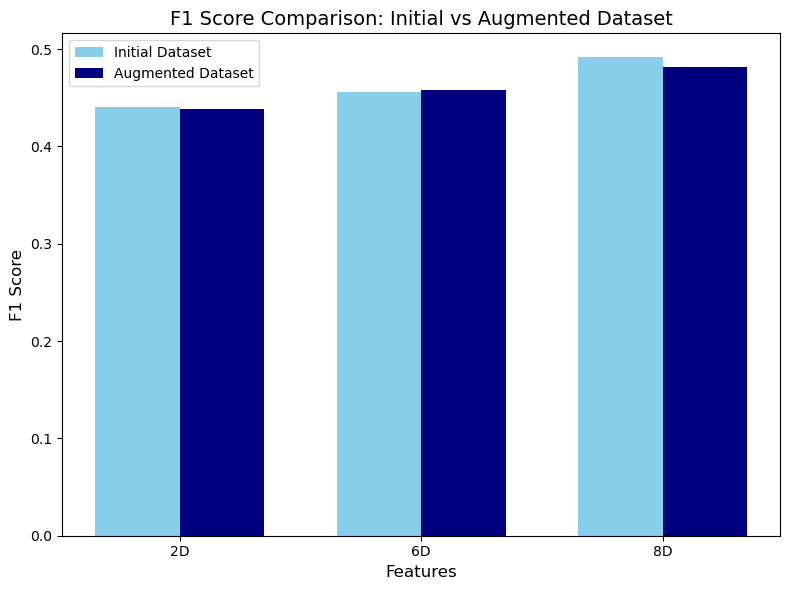

In [51]:
f1_initial = [F1_2, F1_6, F1_8]
f1_augmented = [F1_2_augm, F1_6_augm, F1_8_augm]

features = ['2D', '6D', '8D']

bar_width = 0.35
x = np.arange(len(features))

# Plot
plt.figure(figsize=(8, 6))
plt.bar(x, f1_initial, width=bar_width, color='skyblue',label='Initial Dataset')
plt.bar(x + bar_width, f1_augmented, color='navy',width=bar_width, label='Augmented Dataset')

# Adding labels and title
plt.xlabel('Features', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('F1 Score Comparison: Initial vs Augmented Dataset', fontsize=14)
plt.xticks(x + bar_width / 2, features)
plt.legend()

# Display plot
plt.tight_layout()
plt.show()


## Visualization of the 6 models for one specific image

In [52]:
img_idx = 12

Xi2d = extract_img_features_2d(image_dir + files_train[img_idx])
Xi6d = extract_img_features(image_dir + files_train[img_idx])
Xi8d = np.concatenate((Xi2d, Xi6d), axis=1)


Xi2d = scaler2d.transform(Xi2d)
Xi6d = scaler6d.transform(Xi6d)
Xi8d = scaler8d.transform(Xi8d)  

Xi2d_augm = scaler2d_augm.transform(Xi2d)
Xi6d_augm = scaler6d_augm.transform(Xi6d)
Xi8d_augm = scaler8d_augm.transform(Xi8d)

Zi2d = best_model_2d.predict(Xi2d)
Zi6d = best_model_6d.predict(Xi6d)
Zi8d = best_model_8d.predict(Xi8d)

Zi2d_augm = best_model_2d_augm.predict(Xi2d)
Zi6d_augm = best_model_6d_augm.predict(Xi6d)
Zi8d_augm = best_model_8d_augm.predict(Xi8d)

In [53]:
def display_image(w, h, patch_size, Zi,imgs,img_idx):
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    cimg = concatenate_images(imgs[img_idx], predicted_im)
    fig = plt.figure(figsize=(10, 10))  # create a figure with the default size
    plt.imshow(cimg, cmap="Greys_r")
    new_img = make_img_overlay(imgs[img_idx], predicted_im)
    plt.imshow(new_img)
    plt.show()

2 feature and basic data set:



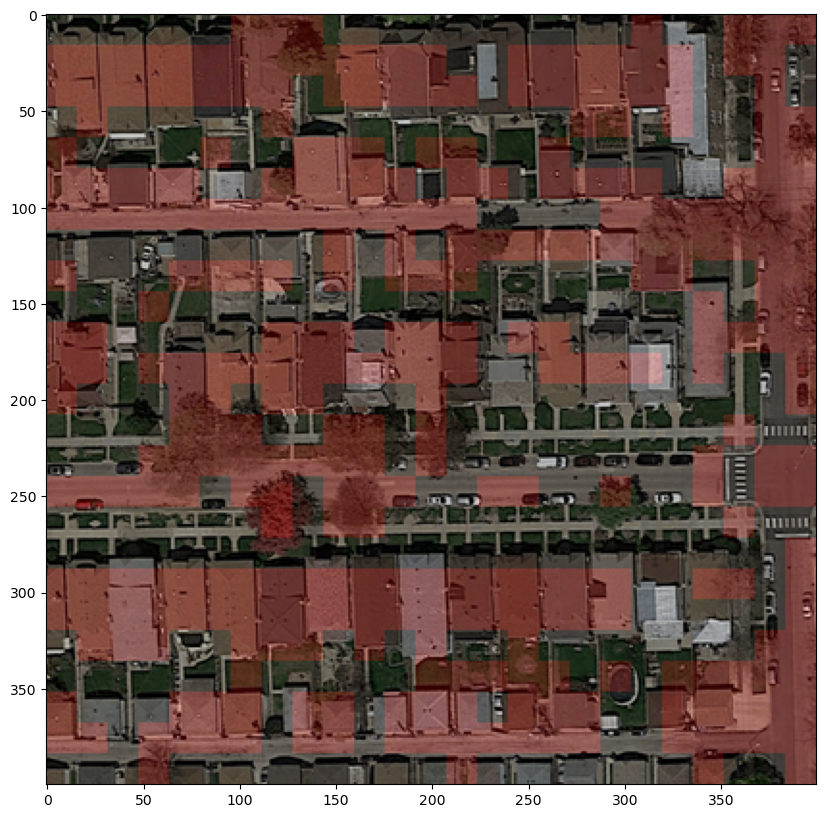

6 feature and basic data set:



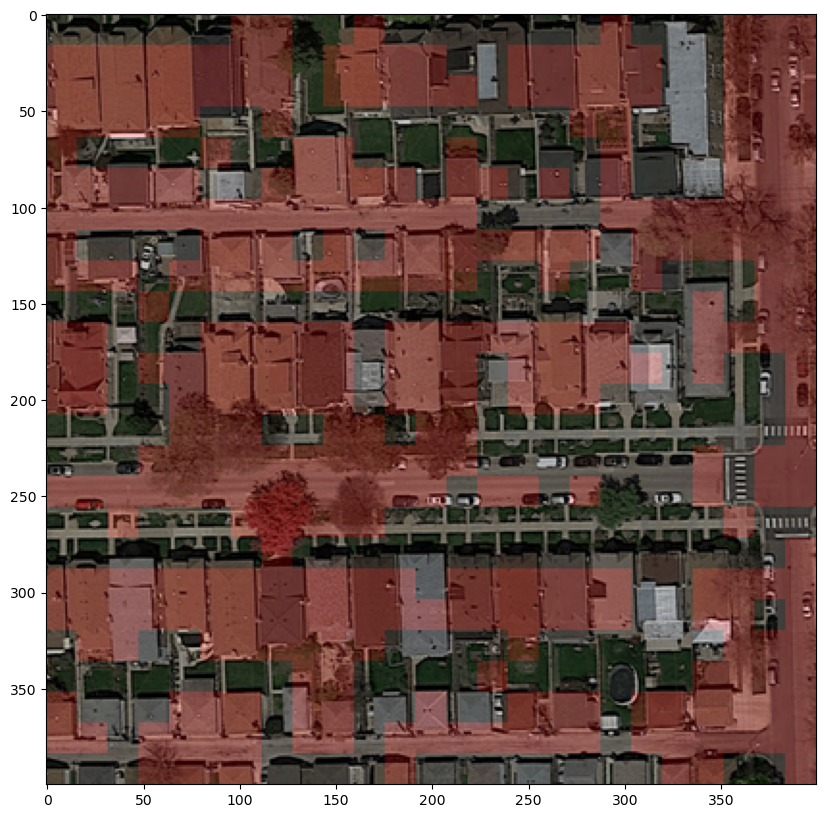

8 feature and basic data set:



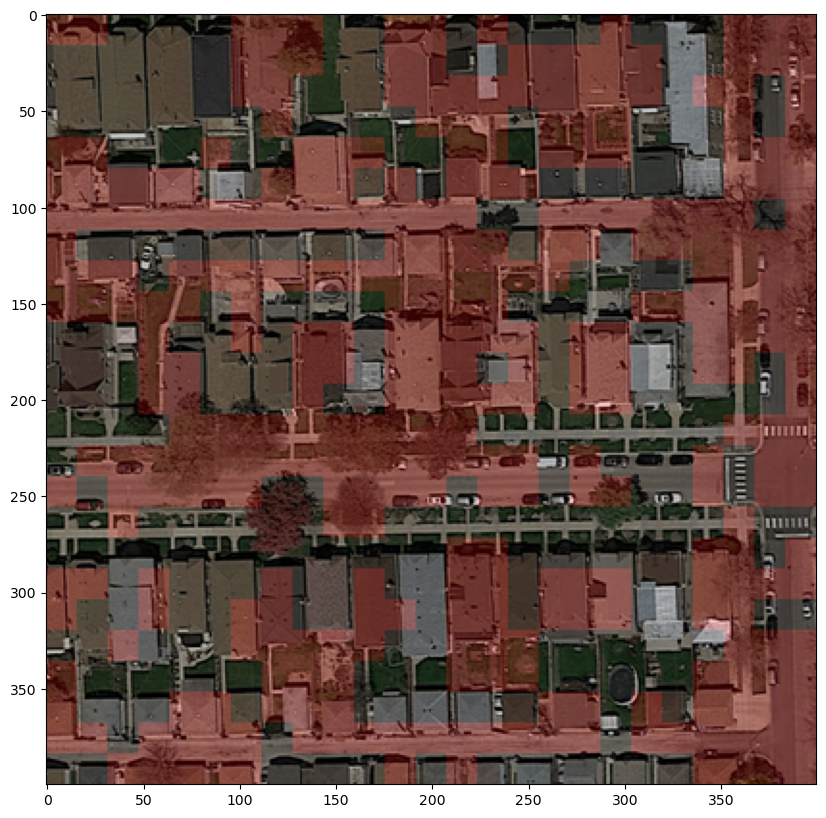



 2 feature and augmented data set:



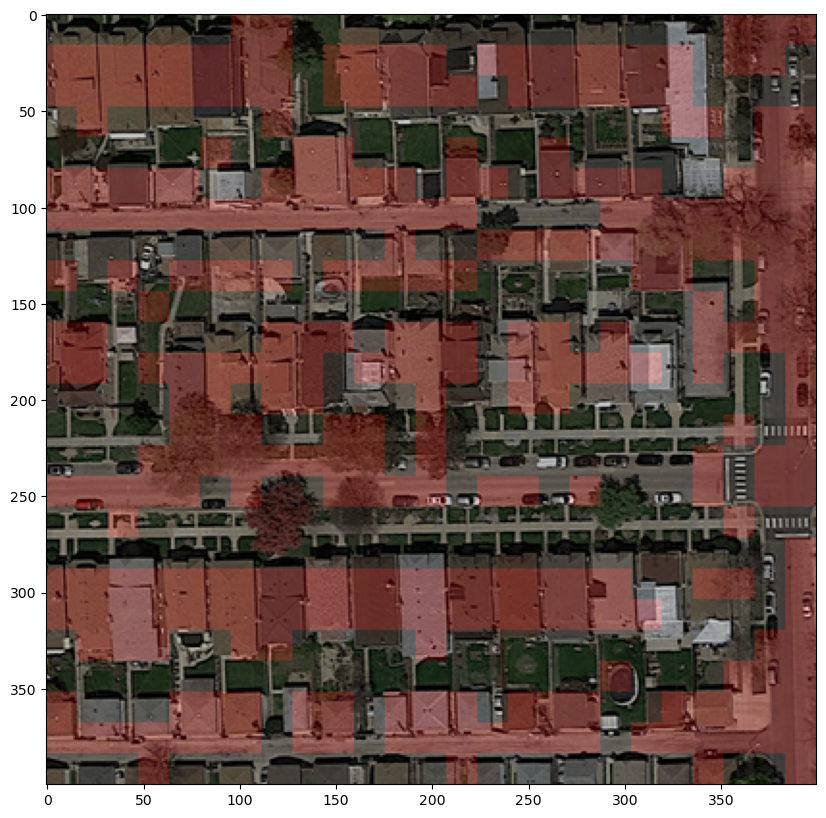

6 feature and augmented data set:



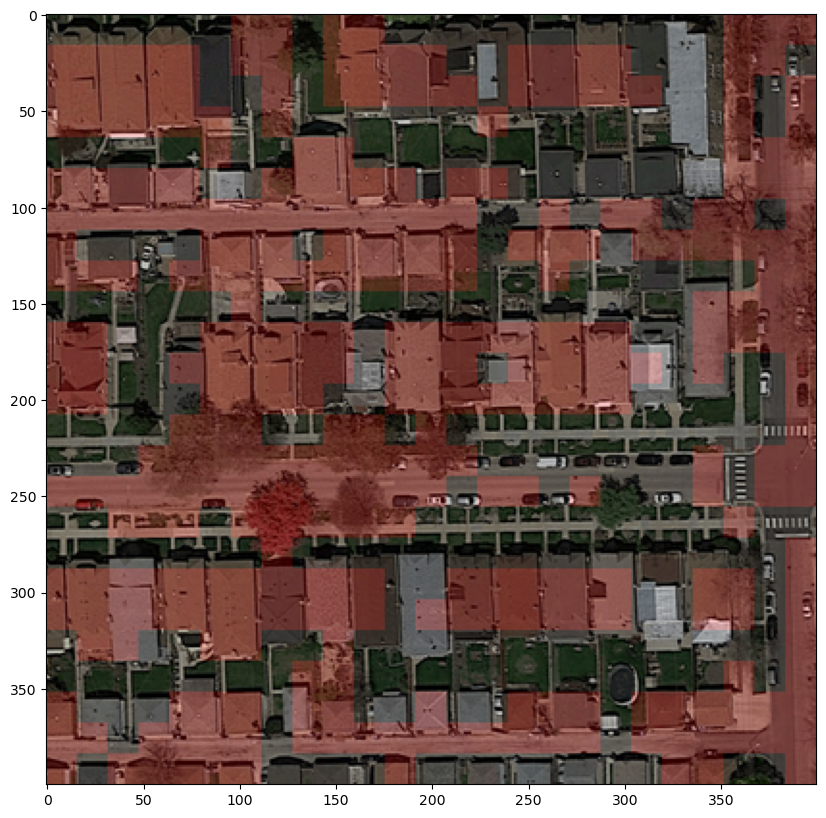

8 feature and augmented data set:



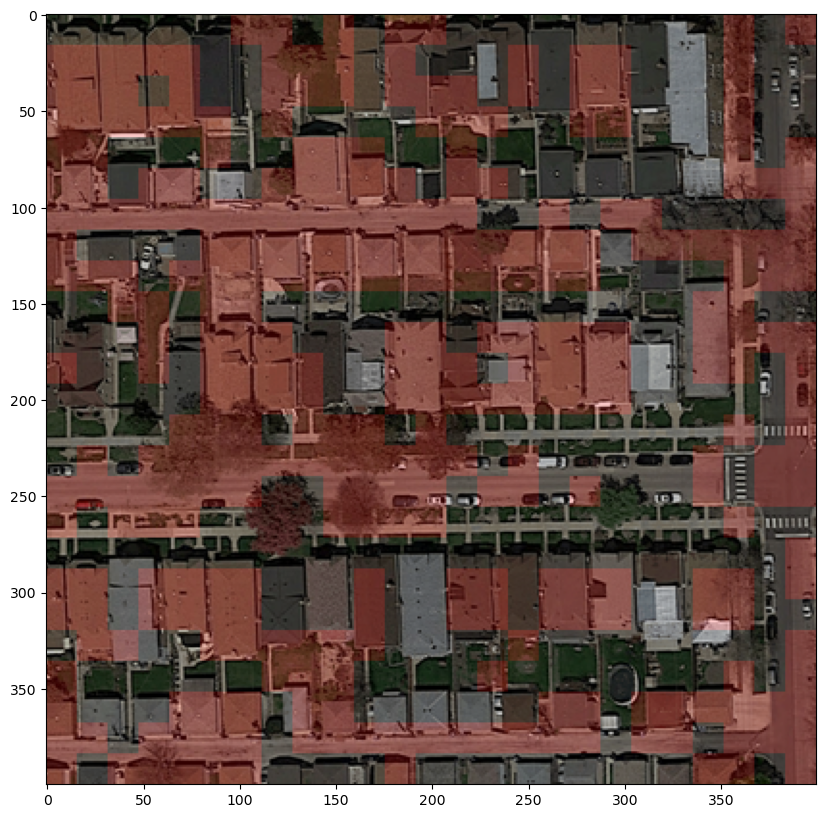

In [67]:
# Display prediction as an image

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
print("2 feature and basic data set:\n")
display_image(w, h, PATCH_SIZE,Zi2d,imgs,img_idx)
print("6 feature and basic data set:\n")
display_image(w, h, PATCH_SIZE,Zi6d,imgs,img_idx)
print("8 feature and basic data set:\n")
display_image(w, h, PATCH_SIZE,Zi8d,imgs,img_idx)
print("\n\n 2 feature and augmented data set:\n")
display_image(w, h, PATCH_SIZE,Zi2d_augm,imgs,img_idx)
print("6 feature and augmented data set:\n")
display_image(w, h, PATCH_SIZE,Zi6d_augm,imgs,img_idx)
print("8 feature and augmented data set:\n")
display_image(w, h, PATCH_SIZE,Zi8d_augm,imgs,img_idx)

## Predictions

In [58]:
root_test_dir = "dataset/test_set_images/"
folder_test = os.listdir(root_test_dir)
n_test = len(folder_test)
imgs_test = [ load_image(os.path.join(root_test_dir, folder_test[i], f"{folder_test[i]}.png")) for i in range(n_test)]
imgs_test_arrays = [np.array(img) / 255 for img in imgs_test]

img_test_patches = [img_crop(imgs_test[i], PATCH_SIZE, PATCH_SIZE) for i in range(n_test)]


# Convert to numpy arrays
img_test_patches = np.array(img_test_patches)

print(f"Shape of unflattened image test patches : {img_test_patches.shape}\n")

# Linearize list of patches
img_test_patches = np.asarray(
    [
        img_test_patches[i][j]
        for i in range(len(img_test_patches))
        for j in range(len(img_test_patches[i]))
    ]
)

print(f"Shape of flattened test image patches : {img_test_patches.shape}\n")


X2d_test = np.asarray([extract_features_2d(img_test_patches[i]) for i in range(len(img_test_patches))])
X6d_test = np.asarray([extract_features(img_test_patches[i]) for i in range(len(img_test_patches))])
X8d_test = np.asarray([np.concatenate((X2d_test[i], X6d_test[i])) for i in range(len(X2d_test))])
print(X2d_test.shape,X6d_test.shape,X8d_test.shape)

Shape of unflattened image test patches : (50, 1444, 16, 16, 3)

Shape of flattened test image patches : (72200, 16, 16, 3)

(72200, 2) (72200, 6) (72200, 8)


In [63]:
X2d_test_scaled = scaler2d.transform(X2d_test)
X6d_test_scaled = scaler6d.transform(X6d_test)
X8d_test_scaled = scaler8d.transform(X8d_test)  

Xi2d_augm_scaled = scaler2d_augm.transform(X2d_test)
Xi6d_augm_scaled = scaler6d_augm.transform(X6d_test)
Xi8d_augm_scaled = scaler8d_augm.transform(X8d_test)

Z2d_test_prediction = best_model_2d.predict(X2d_test_scaled)
Z6d_test_prediction = best_model_6d.predict(X6d_test_scaled)
Z8d_test_prediction = best_model_8d.predict(X8d_test_scaled)

Z2d_augm_test_prediction = best_model_2d_augm.predict(Xi2d_augm_scaled)
Z6d_augm_test_prediction = best_model_6d_augm.predict(Xi6d_augm_scaled)
Z8d_augm_test_prediction = best_model_8d_augm.predict(Xi8d_augm_scaled)

In [65]:
# create submission files

w_test, h_test = imgs_test_arrays[0].shape[:2]
sqrt_n_patches = w_test // PATCH_SIZE

array_to_submission('predictions2d.csv', Z2d_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions6d.csv', Z6d_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions8d.csv', Z8d_test_prediction, sqrt_n_patches, PATCH_SIZE)

array_to_submission('predictions2d_augmented.csv', Z2d_augm_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions6d_augmented.csv', Z6d_augm_test_prediction, sqrt_n_patches, PATCH_SIZE)
array_to_submission('predictions8d_augmented.csv', Z8d_augm_test_prediction, sqrt_n_patches, PATCH_SIZE)